# Feature Engineering with PySpark

The real world is messy and your job is to make sense of it. Toy datasets like MTCars and Iris are the result of careful curation and cleaning, even so the data needs to be transformed for it to be useful for powerful machine learning algorithms to extract meaning, forecast, classify or cluster. This course will cover the gritty details that data scientists are spending 70-80% of their time on; data wrangling and feature engineering. With size of datasets now becoming ever larger, let's use PySpark to cut this Big Data problem down to size!

## Exploratory Data Analysis
Get to know a bit about your problem before you dive in! Then learn how to statistically and visually inspect your dataset!

## Check Version
Checking the version of which Spark and Python installed is important as it changes very quickly and drastically. Reading the wrong documentation can cause lots of lost time and unnecessary frustration!

In [2]:
# Return spark version
print(spark.version)

# Return python version
import sys
print(sys.version_info)

2.4.2
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)


## Load in the data
Reading in data is the first step to using PySpark for data science! Let's leverage the new industry standard of parquet files!

In [3]:
# File Path
file_path = ".../data/datacamp/"

# Read the file into a dataframe
df = spark.read.parquet(file_path + 'real_estate')

# Print columns in dataframe
print(df.columns)

['ROOMFLOOR2', 'SQFTABOVEGROUND', 'ASSESSMENTPENDING', 'TAXYEAR', 'NO', 'TAXES', 'LOTSIZEDIMENSIONS', 'LISTDATE', 'ORIGINALLISTPRICE', 'ROOMFAMILYCHAR', 'PRICEPERTSFT', 'SALESCLOSEPRICE', 'ROOMAREA2', 'ROOMTYPE', 'UNITNUMBER', 'GARAGEDESCRIPTION', 'OFFMARKETDATE', 'FENCE', 'STREETNUMBERNUMERIC', 'TAXWITHASSESSMENTS', 'BATHDESC', 'ROOMAREA1', 'LIVINGAREA', 'STATEORPROVINCE', 'DAYSONMARKET', 'BATHSTOTAL', 'CLASS', 'ASSUMABLEMORTGAGE', 'LISTPRICE', 'FOUNDATIONSIZE', 'STYLE', 'ROOMFLOOR6', 'COOLINGDESCRIPTION', 'ACRES', 'POTENTIALSHORTSALE', 'BACKONMARKETDATE', 'BATHSHALF', 'BATHSFULL', 'ROOMFLOOR3', 'ROOMAREA8', 'PDOM', 'ROOMFLOOR7', 'MLSID', 'SCHOOLDISTRICTNUMBER', 'ASSOCIATIONFEE', 'ROOF', 'ROOMAREA3', 'YEARBUILT', 'BATHSTHREEQUARTER', 'SQFTBELOWGROUND', 'FIREPLACES', 'POOLDESCRIPTION', 'ROOMFLOOR8', 'ROOMFLOOR5', 'ZONING', 'ROOMFLOOR1', 'LISTTYPE', 'APPLIANCES', 'ROOMFLOOR4', 'ASSESSEDVALUATION', 'BASEMENT', 'STREETNAME', 'STREETADDRESS', 'BEDROOMS', 'BATHQUARTER', 'EXTERIOR', 'ROOMARE

## What are we predicting?
Which of these fields (or columns) is the value we are trying to predict for?

- TAXES
- SALESCLOSEPRICE
- DAYSONMARKET
- LISTPRICE

In [4]:
from pyspark.sql.types import *

# Select our dependent variable
Y_df = df.select(df['SALESCLOSEPRICE'])


# Display summary statistics
Y_df.describe().show()

+-------+------------------+
|summary|   SALESCLOSEPRICE|
+-------+------------------+
|  count|              4974|
|   mean|262921.26739043026|
| stddev|140802.40633264554|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



## Verifying Data Load
Let's suppose each month you get a new file. You know to expect a certain number of records and columns. In this exercise we will create a function that will validate the file loaded.

In [5]:
def check_load(df, num_records, num_columns):
  # Takes a dataframe and compares record and column counts to input
  # Message to return if the critera below aren't met
  message = 'Validation Failed'
  # Check number of records
  if num_records == df.count():
    # Check number of columns
    if num_columns == len(df.columns):
      # Success message
      message = 'Validation Passed'
  return message

# Print the data validation message
print(check_load(df, 4974, 74))

Validation Passed


## Verifying DataTypes
In the age of data we have access to more attributes than we ever had before. To handle all of them we will build a lot of automation but at a minimum requires that their datatypes be correct. In this exercise we will validate a dictionary of attributes and their datatypes to see if they are correct. This dictionary is stored in the variable validation_dict and is available in your workspace.

In [6]:
validation_dict = {'ASSESSMENTPENDING': 'string',
 'AssessedValuation': 'double',
 'AssociationFee': 'bigint',
 'AssumableMortgage': 'string',
 'SQFTBELOWGROUND': 'bigint'}

# create list of actual dtypes to check
actual_dtypes_list = df.dtypes
# print(actual_dtypes_list)

# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
  # Check if column name is dictionary of expected dtypes
  col_name = attribute_tuple[0]
  if col_name in validation_dict.keys():

    # Compare attribute types
    col_type = attribute_tuple[1]
    if col_type == validation_dict[col_name]:
      print(col_name + ' has expected dtype.')

ASSESSMENTPENDING has expected dtype.
SQFTBELOWGROUND has expected dtype.


You've created a way to loop through your expected dtypes and compare them to how they got loaded. You could use a similar loop to print or count all the numeric or text fields if you don't have a list of verified field types to compare against.

## Using Corr()
The old adage 'Correlation does not imply Causation' is a cautionary tale. However, correlation does give us a good nudge to know where to start looking promising features to use in our models. Use this exercise to get a feel for searching through your data for the first time, trying to find patterns.

In [7]:
from pyspark.sql.functions import col

columns = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES', 'PDOM', 'SQFTABOVEGROUND', 'TAXES', 'TAXWITHASSESSMENTS', 'TAXYEAR', 'LIVINGAREA', 'YEARBUILT', 'ACRES', 'BACKONMARKETDATE', 'BATHSFULL', 'BATHSHALF', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'BATHSTOTAL', 'BEDROOMS', 'SQFTBELOWGROUND', 'ASSOCIATIONFEE', 'ASSESSEDVALUATION']

# Making numerical columns are of type float
df2 = df.select(*(col(c).cast("float").alias(c) for c in columns + ['SALESCLOSEPRICE']))

# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df2.corr(col, 'SALESCLOSEPRICE')
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


It makes sense that homes with larger living areas would be correlated with more expensive homes!

## Using Visualizations: distplot
Understanding the distribution of our dependent variable is very important and can impact the type of model or preprocessing we do. A great way to do this is to plot it, however plotting is not a built in function in PySpark, we will need to take some intermediary steps to make sure it works correctly. In this exercise you will visualize the variable the 'LISTPRICE' variable, and you will gain more insights on its distribution by computing the skewness.

In [8]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} seaborn

from matplotlib import pyplot as plt
import seaborn as sns

Solving environment: done

# All requested packages already installed.



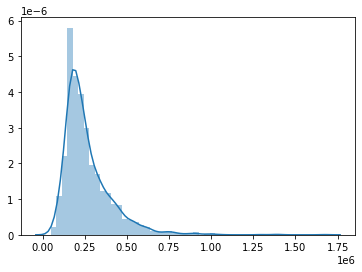

[Row(skewness(LISTPRICE)=2.7885521224231247)]


In [9]:
# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

Awesome, checking the distribution visually is a great way to get an idea of what steps will need to be taken before applying a model. We can see the 'ListPrice' is mostly pushed to the left, which means its skewed. We can use the skewness function to verify this numerically rather than visually.

## Using Visualizations: lmplot
Creating linear model plots helps us visualize if variables have relationships with the dependent variable. If they do they are good candidates to include in our analysis. If they don't it doesn't mean that we should throw them out, it means we may have to process or wrangle them before they can be used.

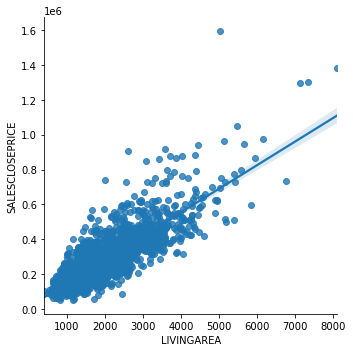

In [10]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()

Well done, now we can see that as LivingArea increases, the price of the home increases at a relatively steady rate.